# Stability Analysis: PCA and Clustering of RNA-seq Data

## Overview
This notebook performs stability analysis of RNA-seq data across different timepoints and samples using PCA clustering and DESeq2 differential expression analysis.

## Analysis Workflow
1. **Data Loading & Quality Control**: Load count data and metadata, perform initial QC
2. **Filtering**: Apply count thresholds and sample filtering
3. **DESeq2 Analysis**: Normalize data and perform differential expression analysis
4. **Batch Correction**: Remove batch effects for visualization
5. **PCA Analysis**: Generate PCA plots for sample and time relationships
6. **Visualization**: Create publication-ready plots

## Input Files
- `bulk/stability_timepoints.tsv`: RNA-seq count matrix
- `bulk/stability_timepoints_meta.tsv`: Sample metadata

## Output Files
- `stability_plots/`: Directory containing all generated plots
- Normalized count matrices and DESeq2 results

## Requirements
- DESeq2, ggplot2, dplyr, limma, pheatmap, vsn
- Input data files in the specified locations

## Configuration and Parameters

In [ ]:
# =============================================================================
# CONFIGURATION AND PARAMETERS
# =============================================================================

# Set seed for reproducibility
set.seed(42)

# File paths
INPUT_DATA_PATH <- "bulk/stability_timepoints.tsv"
INPUT_META_PATH <- "bulk/stability_timepoints_meta.tsv"
OUTPUT_DIR <- "stability_plots"

# Analysis parameters
MIN_COUNT_THRESHOLD <- 0  # Minimum total counts per sample
MIN_READS_PER_GENE <- 10  # Minimum reads per gene for filtering
P_VALUE_CUTOFF <- 0.05    # P-value cutoff for significance
FC_CUTOFF <- 1           # Fold change cutoff for volcano plots

# Plot parameters
PLOT_WIDTH <- 8
PLOT_HEIGHT <- 6
POINT_SIZE <- 3

# Create output directory if it doesn't exist
if (!dir.exists(OUTPUT_DIR)) {
  dir.create(OUTPUT_DIR, recursive = TRUE)
}

cat("Configuration loaded successfully!\n")
cat("Output directory:", OUTPUT_DIR, "\n")
cat("Minimum count threshold:", MIN_COUNT_THRESHOLD, "\n")

## Library Loading

In [ ]:
# =============================================================================
# LIBRARY LOADING
# =============================================================================

# Core analysis packages
suppressPackageStartupMessages({
  library(DESeq2)           # Differential expression analysis
  library(dplyr)            # Data manipulation
  library(ggplot2)          # Plotting
  library(limma)            # Batch effect removal
  library(pheatmap)         # Heatmap plotting
  library(vsn)              # Variance stabilization
})

# Visualization packages
suppressPackageStartupMessages({
  library(EnhancedVolcano)  # Volcano plots
  library(gridExtra)        # Plot arrangement
  library(repr)             # Jupyter notebook plotting
})

# Utility packages
suppressPackageStartupMessages({
  library(useful)           # Utility functions
  library(biomaRt)          # Gene annotation (if needed)
})

# Print session information for reproducibility
cat("Libraries loaded successfully!\n")
cat("R version:", R.version.string, "\n")
cat("Analysis started:", Sys.time(), "\n")

Possible Ensembl SSL connectivity problems detected.
Please see the 'Connection Troubleshooting' section of the biomaRt vignette
vignette('accessing_ensembl', package = 'biomaRt')Error in curl::curl_fetch_memory(url, handle = handle) : 
  SSL certificate problem: certificate has expired




## 1. Data Loading and Initial Inspection

In [ ]:
# =============================================================================
# DATA LOADING
# =============================================================================

# Load count data and metadata
cat("Loading data...\n")

# Load count matrix
if (!file.exists(INPUT_DATA_PATH)) {
  stop("Count data file not found: ", INPUT_DATA_PATH)
}
data <- read.csv(INPUT_DATA_PATH, sep="\t", header=TRUE, quote="", row.names=1)

# Load metadata
if (!file.exists(INPUT_META_PATH)) {
  stop("Metadata file not found: ", INPUT_META_PATH)
}
meta <- read.csv(INPUT_META_PATH, sep="\t", header=TRUE, row.names=1, quote="")

# Basic data inspection
cat("Data dimensions:\n")
cat("  Count matrix:", dim(data)[1], "genes x", dim(data)[2], "samples\n")
cat("  Metadata:", dim(meta)[1], "samples x", dim(meta)[2], "variables\n")

# Display data structure
cat("\nFirst few rows and columns of count data:\n")
corner(data)

,Stability_d21_sample_9,Stability_d21_sample_4,Stability_d21_sample_5,Stability_d21_sample_10,Stability_d21_sample_7
,<int>,<int>,<int>,<int>,<int>
5S_rRNA,0,6,0,0,0
5_8S_rRNA,0,0,0,0,0
7SK,0,0,0,0,1
A1BG,3,6,5,4,21
A1BG-AS1,5,13,11,4,4


In [ ]:
# Display metadata structure
cat("Metadata structure:\n")
head(meta)
cat("\nMetadata summary:\n")
str(meta)

,t,sample,t_int
,<chr>,<int>,<int>
Stability_d21_sample_9,d21,9,21
Stability_d21_sample_4,d21,4,21
Stability_d21_sample_5,d21,5,21
Stability_d21_sample_10,d21,10,21
Stability_d21_sample_7,d21,7,21
Stability_d21_sample_6,d21,6,21


## 2. Quality Control Analysis

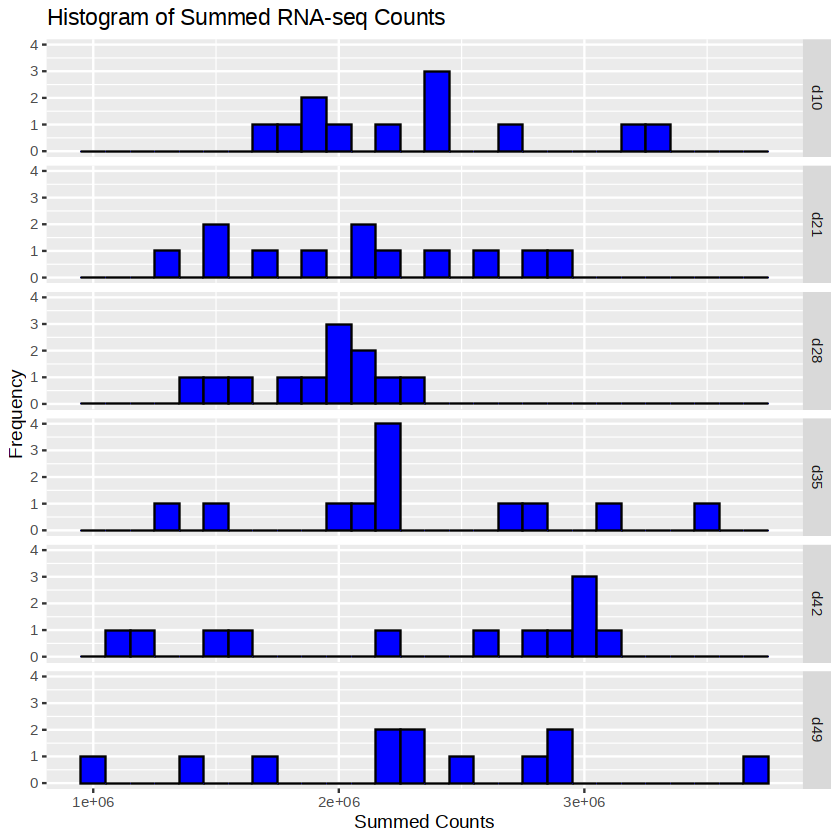

                         counts
Stability_d49_sample_1   993984
Stability_d42_sample_12 1080598
Stability_d42_sample_11 1181846
Stability_d35_sample_1  1285938
Stability_d21_sample_1  1305302
Stability_d49_sample_2  1378173
Stability_d28_sample_5  1427974
Stability_d21_sample_2  1457116
Stability_d35_sample_2  1465541
Stability_d21_sample_9  1492186
Stability_d42_sample_10 1499447
Stability_d28_sample_12 1511447
Stability_d42_sample_9  1623921
Stability_d28_sample_4  1645883
Stability_d21_sample_4  1667503
Stability_d10_sample_12 1699649
Stability_d49_sample_3  1719601
Stability_d28_sample_6  1807912
Stability_d10_sample_11 1822397
Stability_d10_sample_9  1851657


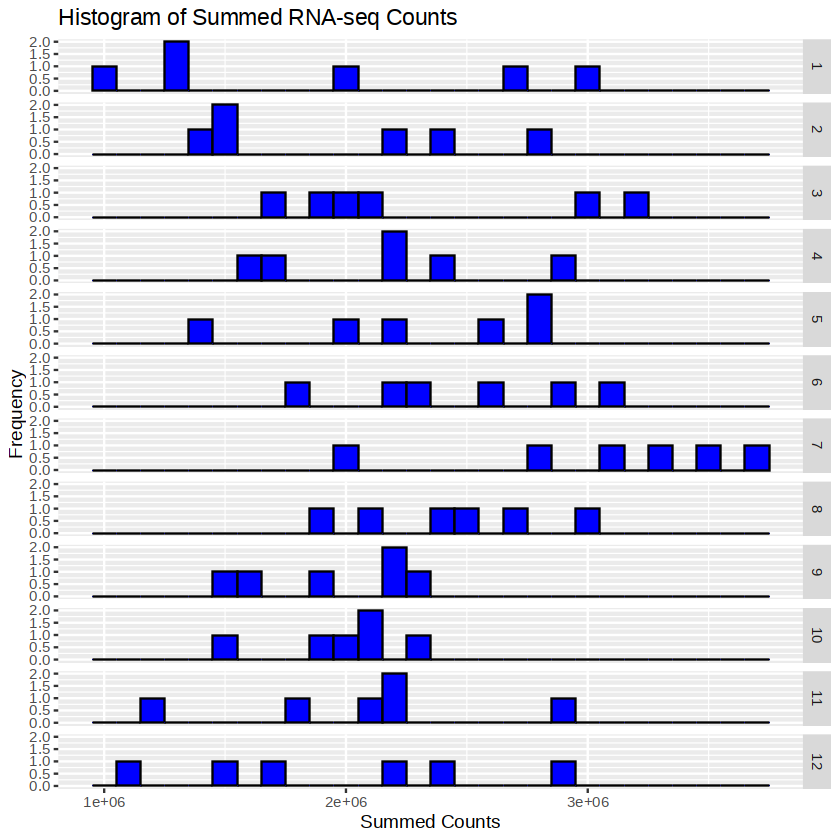

In [ ]:
# =============================================================================
# QUALITY CONTROL: LIBRARY SIZE ANALYSIS
# =============================================================================

# Calculate total counts per sample
sample_counts <- colSums(data)
meta$counts <- sample_counts

# Basic statistics
cat("Library size statistics:\n")
cat("  Mean:", round(mean(sample_counts)), "\n")
cat("  Median:", round(median(sample_counts)), "\n")
cat("  Min:", round(min(sample_counts)), "\n")
cat("  Max:", round(max(sample_counts)), "\n")

# Identify samples with lowest counts
lowest_counts <- data.frame(
  sample = names(sort(sample_counts)[1:5]),
  counts = sort(sample_counts)[1:5]
)
cat("\nSamples with lowest library sizes:\n")
print(lowest_counts)

# Create QC plots
p1 <- ggplot(meta, aes(x = counts)) +
  geom_histogram(binwidth = 100000, fill = 'darkgrey', color = 'black', alpha = 0.7) +
  ggtitle('Distribution of Library Sizes') +
  xlab('Total Counts per Sample') +
  ylab('Number of Samples') +
  facet_grid(t ~ ., scales = "free_y") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    strip.text = element_text(size = 12, face = "bold")
  )

print(p1)

# Save the plot
ggsave(file.path(OUTPUT_DIR, "QC_library_sizes_by_timepoint.pdf"), 
       plot = p1, width = PLOT_WIDTH, height = PLOT_HEIGHT)


In [ ]:
# =============================================================================
# DATA FILTERING
# =============================================================================

# Apply minimum count threshold (configured at top of notebook)
cat("Applying sample filtering with minimum count threshold:", MIN_COUNT_THRESHOLD, "\n")

# Identify samples that pass the threshold
samples_passing <- colSums(data) >= MIN_COUNT_THRESHOLD
cat("Samples before filtering:", ncol(data), "\n")
cat("Samples after filtering:", sum(samples_passing), "\n")

# Filter data and metadata
filtered_data <- data[, samples_passing]
filtered_meta <- meta[samples_passing, ]

# Report filtering results
cat("Removed", sum(!samples_passing), "samples due to low library size\n")
if (sum(!samples_passing) > 0) {
  removed_samples <- names(which(!samples_passing))
  cat("Removed samples:", paste(removed_samples, collapse = ", "), "\n")
}

## 3. Data Filtering

In [ ]:
# Verify filtering results
cat("Filtered data dimensions:\n")
cat("  Metadata:", nrow(filtered_meta), "samples x", ncol(filtered_meta), "variables\n")

[1] 72  4

In [ ]:
cat("  Count matrix:", nrow(filtered_data), "genes x", ncol(filtered_data), "samples\n")

[1] 61578    72

## 4. DESeq2 Analysis Setup

In [ ]:
# =============================================================================
# DESEQ2 METADATA PREPARATION
# =============================================================================

# Prepare metadata for DESeq2 analysis
deseq2.colData <- filtered_meta
deseq2.colData$sums <- colSums(filtered_data)

# Convert categorical variables to factors
columns_to_factor <- c("sample", "t")
deseq2.colData <- deseq2.colData %>%
  mutate_at(vars(all_of(columns_to_factor)), factor)

# Scale numeric variables for analysis
numeric_columns_to_scale <- c("t_int")
deseq2.colData <- deseq2.colData %>%
  mutate_at(vars(all_of(numeric_columns_to_scale)), ~ scale(log(. + 1)))

cat("DESeq2 metadata prepared successfully\n")
cat("Factor variables:", paste(columns_to_factor, collapse = ", "), "\n")
cat("Scaled variables:", paste(numeric_columns_to_scale, collapse = ", "), "\n")

In [ ]:
# Display prepared metadata
cat("Prepared DESeq2 metadata:\n")
corner(deseq2.colData)

,t,sample,t_int,counts,sums
,<chr>,<int>,<int>,<dbl>,<dbl>
Stability_d21_sample_9,d21,9,21,1492186,1492186
Stability_d21_sample_4,d21,4,21,1667503,1667503
Stability_d21_sample_5,d21,5,21,2616749,2616749
Stability_d21_sample_10,d21,10,21,2144150,2144150
Stability_d21_sample_7,d21,7,21,2835663,2835663


In [ ]:
# Display final metadata structure
cat("Final DESeq2 metadata structure:\n")
str(deseq2.colData)
head(deseq2.colData)

,t,sample,t_int,counts,sums
,<fct>,<fct>,"<dbl[,1]>",<dbl>,<dbl>
Stability_d21_sample_9,d21,9,-0.5163136,1492186,1492186
Stability_d21_sample_4,d21,4,-0.5163136,1667503,1667503
Stability_d21_sample_5,d21,5,-0.5163136,2616749,2616749
Stability_d21_sample_10,d21,10,-0.5163136,2144150,2144150
Stability_d21_sample_7,d21,7,-0.5163136,2835663,2835663
Stability_d21_sample_6,d21,6,-0.5163136,2928478,2928478
Stability_d21_sample_1,d21,1,-0.5163136,1305302,1305302
Stability_d21_sample_12,d21,12,-0.5163136,2406280,2406280
Stability_d21_sample_3,d21,3,-0.5163136,1869330,1869330


In [ ]:
# =============================================================================
# DESEQ2 OBJECT CREATION
# =============================================================================

# Create DESeq2 object
cat("Creating DESeq2 object...\n")

# Ensure row names match between count data and metadata
rownames(deseq2.colData) <- colnames(filtered_data)

# Create DESeqDataSet with appropriate design formula
dds <- DESeqDataSetFromMatrix(
  countData = filtered_data, 
  colData = deseq2.colData,
  design = ~ t_int + sample  # Controlling for sample effects while testing time
)

cat("DESeq2 object created successfully\n")
cat("Design formula: ~ t_int + sample\n")

## 5. DESeq2 Analysis Execution

In [ ]:
# Verify metadata column names
cat("Available metadata columns:\n")
print(colnames(deseq2.colData))

[1] "t"      "sample" "t_int"  "counts" "sums"

In [ ]:
# =============================================================================
# GENE FILTERING AND DESEQ2 ANALYSIS
# =============================================================================

# Filter genes with low expression
cat("Applying gene filtering...\n")
cat("Minimum reads per gene:", MIN_READS_PER_GENE, "\n")

genes_passing <- rowSums(counts(dds)) >= MIN_READS_PER_GENE
cat("Genes before filtering:", nrow(dds), "\n")
cat("Genes after filtering:", sum(genes_passing), "\n")

# Apply filtering
dds <- dds[genes_passing, ]

# Run DESeq2 analysis
cat("Running DESeq2 analysis...\n")
dds <- DESeq(dds)

# Extract results
res <- results(dds)
res <- res[order(rownames(res)), ]

cat("DESeq2 analysis completed successfully\n")

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [17]:
table(mcols(dds)$betaConv)


 TRUE 
29162 

In [18]:
#save median normalised counts
normalized_counts <- counts(dds, normalized=TRUE)
#write.table(normalized_counts, file="bulk/DESEQ2_norm_counts_stranded.tsv", sep="\t", quote=F, col.names=NA) 

In [ ]:
# =============================================================================
# VARIANCE STABILIZING TRANSFORMATION
# =============================================================================

# Apply variance stabilizing transformation
cat("Applying variance stabilizing transformation...\n")
vsd <- vst(dds, blind = FALSE)

# Store original transformed data
vsd_orig <- vsd

cat("VST transformation completed\n")

## 6. Data Transformation and Batch Correction

In [ ]:
# =============================================================================
# PCA PLOTTING HELPER FUNCTIONS
# =============================================================================

# Function to create consistent PCA plots
create_pca_plot <- function(vsd_object, title, plot_var, filename, 
                           fill_color_map = NULL, outline_color_map = NULL,
                           is_continuous = FALSE, aspect_ratio = 1, 
                           width = PLOT_WIDTH, height = PLOT_HEIGHT) {
  
  # Generate base PCA plot
  p <- plotPCA(object = vsd_object, intgroup = c(plot_var)) +
    ggtitle(title) +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
      axis.title.x = element_text(size = 16, margin = margin(t = 10)),
      axis.title.y = element_text(size = 16, margin = margin(r = 10)),
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 14),
      legend.title = element_text(size = 14),
      legend.text = element_text(size = 12),
      panel.grid.major = element_line(color = "gray80"),
      panel.grid.minor = element_blank()
    ) +
    coord_fixed(ratio = aspect_ratio)
  
  if (is_continuous) {
    # For continuous variables
    p <- p + geom_point(aes(color = !!sym(plot_var)), size = POINT_SIZE, alpha = 0.8) +
             scale_color_gradient(low = "grey", high = "black")
  } else {
    # For categorical variables
    if (!is.null(fill_color_map) && !is.null(outline_color_map)) {
      p <- p + geom_point(aes(color = !!sym(plot_var), fill = !!sym(plot_var)), 
                         size = POINT_SIZE, shape = 21, stroke = 1.5) +
               scale_fill_manual(values = fill_color_map) +
               scale_color_manual(values = outline_color_map)
    } else {
      p <- p + geom_point(aes(color = !!sym(plot_var)), size = POINT_SIZE, alpha = 0.8)
    }
  }
  
  # Display and save plot
  print(p)
  ggsave(file.path(OUTPUT_DIR, filename), plot = p, width = width, height = height)
  
  return(p)
}

cat("PCA plotting functions defined\n")

In [ ]:
# =============================================================================
# SAMPLE COLOR CONFIGURATION
# =============================================================================

# Define sample ID mapping
sample2ID <- c(
  '1' = 'p1_D4', '2' = 'p1_D8', '3' = 'p1_D10',
  '4' = 'p1_B4', '5' = 'p1_B8', '6' = 'p1_B10',
  '7' = 'p3_C2', '8' = 'p3_F2', '9' = 'p3_D1',
  '10' = 'p3_F4', '11' = 'p3_G1', '12' = 'p3_G10'
)

# Define color schemes for visualization
fill_color_map <- c(
  'p1_D4' = '#ffffff', 'p1_D8' = '#66557d', 'p1_D10' = '#6199b4',
  'p1_B4' = '#ffd762', 'p1_B8' = '#ab8c62', 'p1_B10' = '#a8b180',
  'p3_C2' = '#ffffff', 'p3_F2' = '#ffffff', 'p3_D1' = '#cc623f',
  'p3_F4' = '#9a7da7', 'p3_G1' = '#ffffff', 'p3_G10' = '#b8b78b'
)

outline_color_map <- c(
  'p1_D4' = '#CBCCCC', 'p1_D8' = '#CBCCCC', 'p1_D10' = '#CBCCCC',
  'p1_B4' = '#CBCCCC', 'p1_B8' = '#CBCCCC', 'p1_B10' = '#CBCCCC',
  'p3_C2' = '#4E835E', 'p3_F2' = '#8DC7DD', 'p3_D1' = '#8DC7DD',
  'p3_F4' = '#8DC7DD', 'p3_G1' = '#102A4D', 'p3_G10' = '#102A4D'
)

cat("Sample color configuration loaded\n")

## 7. PCA Analysis

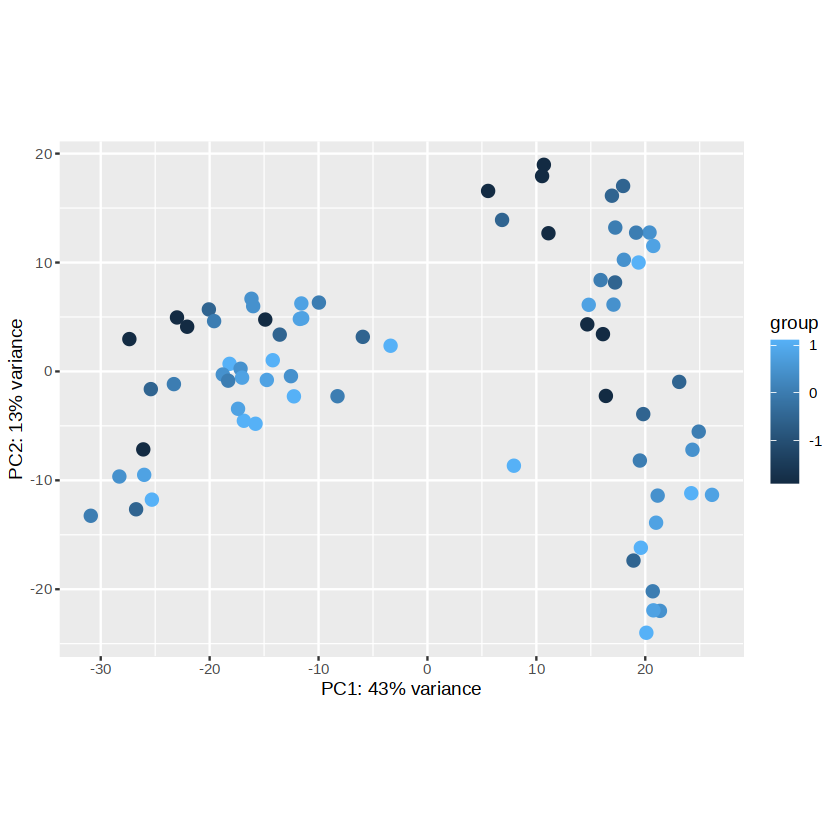

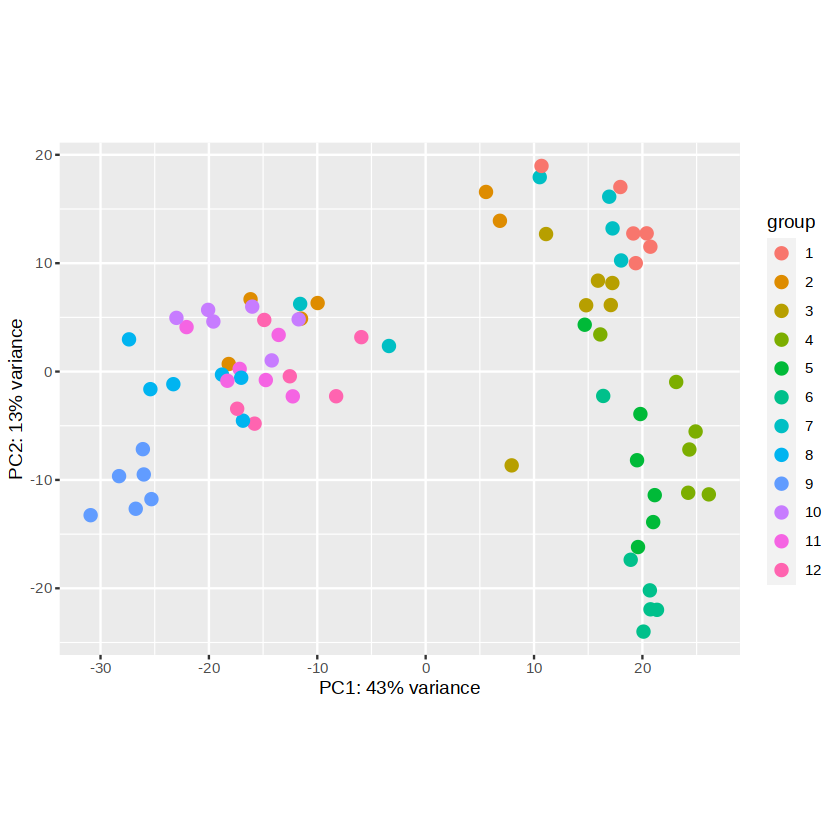

In [ ]:
# =============================================================================
# PCA ANALYSIS - ORIGINAL DATA (BEFORE BATCH CORRECTION)
# =============================================================================

# Create PCA plots for original data (before batch correction)
cat("Creating PCA plots for original data...\n")

# Add sample IDs to the data
vsd_orig$sampleID <- factor(sample2ID[as.character(vsd_orig$sample)], 
                           levels = names(fill_color_map))

# Plot by time (continuous variable)
create_pca_plot(vsd_orig, "PCA: Time Effect (Original)", "t_int", 
               "PCA_original_time.pdf", is_continuous = TRUE)

# Plot by sample ID (categorical)  
create_pca_plot(vsd_orig, "PCA: Sample Effect (Original)", "sampleID",
               "PCA_original_sample.pdf", fill_color_map, outline_color_map)

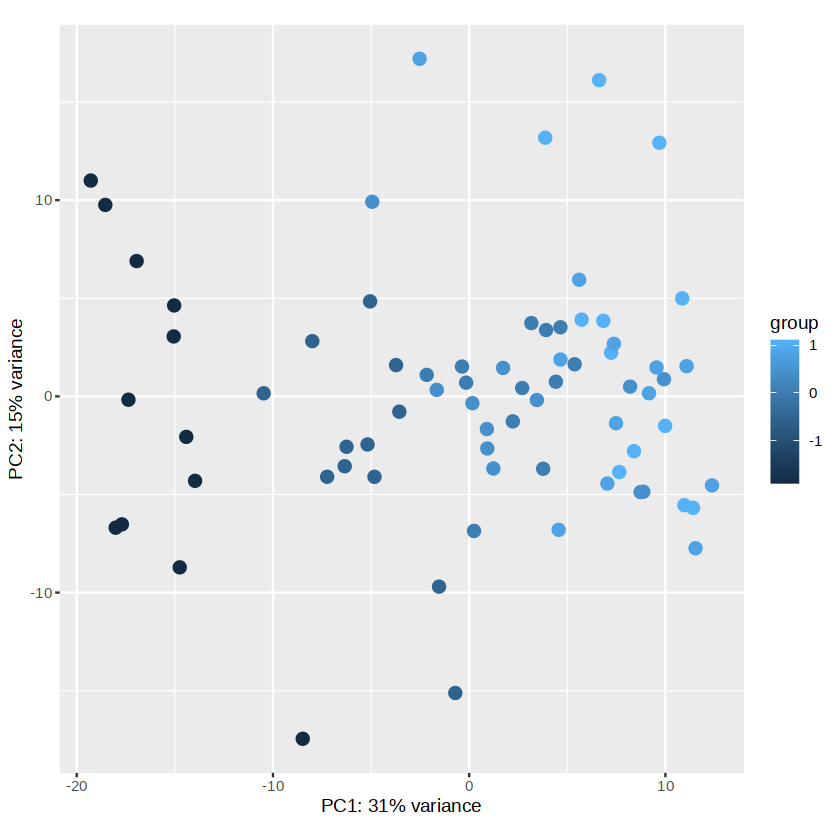

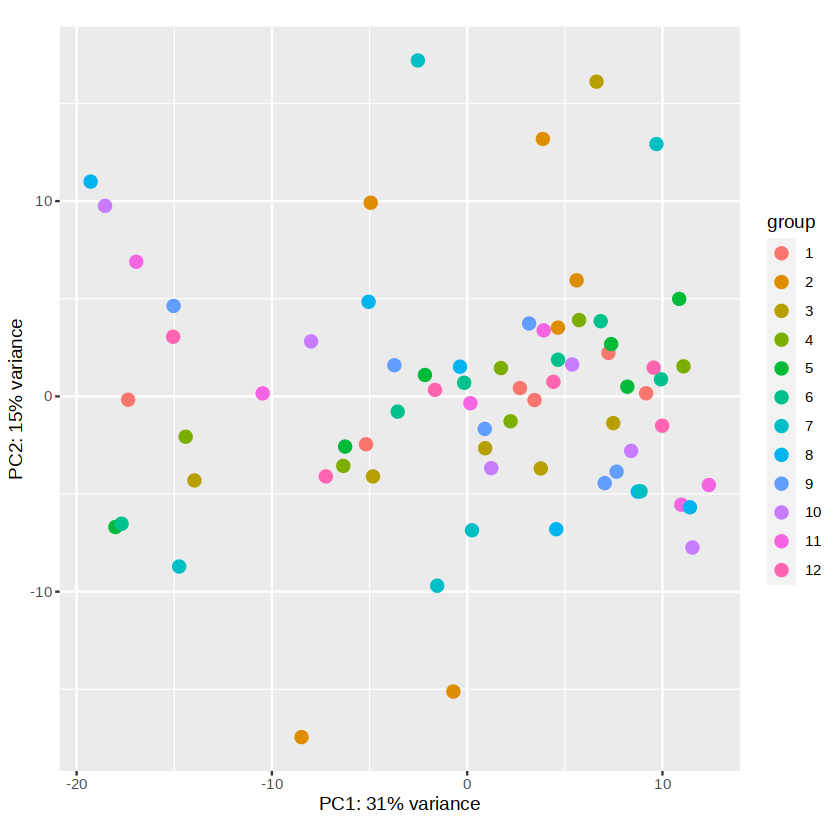

In [ ]:
# =============================================================================
# BATCH CORRECTION WITH LIMMA
# =============================================================================

cat("Applying batch correction...\n")

# Create a copy for batch correction
vsd_batchcorr <- vsd
mat <- assay(vsd_batchcorr)

# Remove batch effects while preserving time effects
mm <- model.matrix(~t_int, colData(vsd_batchcorr))
mat <- limma::removeBatchEffect(mat, batch = vsd_batchcorr$sample, design = mm)
assay(vsd_batchcorr) <- mat

# Add sample IDs for plotting
vsd_batchcorr$sampleID <- factor(sample2ID[as.character(vsd_batchcorr$sample)], 
                                levels = names(fill_color_map))

# Create PCA plots for batch-corrected data
cat("Creating PCA plots for batch-corrected data...\n")

# Plot by time (continuous variable)
create_pca_plot(vsd_batchcorr, "PCA: Time Effect (Batch Corrected)", "t_int", 
               "PCA_batchcorr_time.pdf", is_continuous = TRUE)

# Plot by sample ID (categorical)  
create_pca_plot(vsd_batchcorr, "PCA: Sample Effect (Batch Corrected)", "sampleID",
               "PCA_batchcorr_sample.pdf", fill_color_map, outline_color_map)

# Store batch-corrected data for further analysis
vsd_samplecorr <- vsd_batchcorr

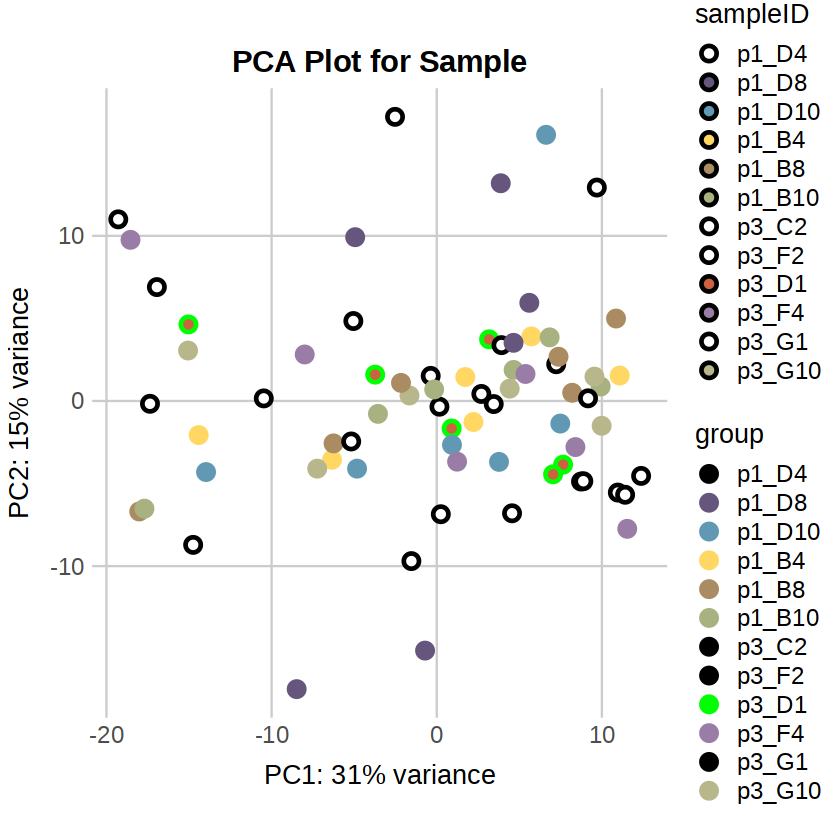

In [23]:
# Load necessary libraries
library(ggplot2)
library(DESeq2)  # Assuming you're using DESeq2 for vsd_samplecorr

# Step 1: Define sample to ID mapping and two color mappings
sample2ID <- c(
  '1' = 'p1_D4',
  '2' = 'p1_D8',
  '3' = 'p1_D10',
  '4' = 'p1_B4',
  '5' = 'p1_B8',
  '6' = 'p1_B10',
  '7' = 'p3_C2',
  '8' = 'p3_F2',
  '9' = 'p3_D1',
  '10' = 'p3_F4',
  '11' = 'p3_G1',
  '12' = 'p3_G10'
)

fill_color_map <- c(
  'p1_D4' = '#ffffff',
  'p1_D8' = '#66557d',
  'p1_D10' = '#6199b4',
  'p1_B4' = '#ffd762',
  'p1_B8' = '#ab8c62',
  'p1_B10' = '#a8b180',
  'p3_C2' = '#ffffff',
  'p3_F2' = '#ffffff',
  'p3_D1' = '#cc623f',
  'p3_F4' = '#9a7da7',
  'p3_G1' = '#ffffff',
  'p3_G10' = '#b8b78b'
)


outline_color_map <- c(
  'p1_D4' = 'black',
  'p1_D8' = '#66557d',
  'p1_D10' = '#6199b4',
  'p1_B4' = '#ffd762',
  'p1_B8' = '#ab8c62',
  'p1_B10' = '#a8b180',
  'p3_C2' = 'black',
  'p3_F2' = 'black',
  'p3_D1' = 'green',
  'p3_F4' = '#9a7da7',
  'p3_G1' = 'black',
  'p3_G10' = '#b8b78b'
)

# Step 2: Map 'sample' numbers to their corresponding IDs
vsd_samplecorr$sampleID <- factor(sample2ID[as.character(vsd_samplecorr$sample)], levels = names(fill_color_map))

# Create the PCA plot for 'sample' with custom fill and outline colors
p_sample <- plotPCA(object = vsd_samplecorr, intgroup = c('sampleID')) +
  ggtitle('PCA Plot for Sample') +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
    axis.title.x = element_text(size = 16, margin = margin(t = 10)),
    axis.title.y = element_text(size = 16, margin = margin(r = 10)),
    axis.text.x = element_text(size = 14),
    axis.text.y = element_text(size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14),
    panel.grid.major = element_line(color = "gray80"),
    panel.grid.minor = element_blank()
  ) +
  geom_point(aes(color = sampleID, fill = sampleID), size = 3, shape = 21, stroke = 1.5) +
  scale_fill_manual(values = fill_color_map) +  # Apply custom fill colors
  scale_color_manual(values = outline_color_map)  # Apply custom outline colors

# Display the 'sample' plot in the notebook
print(p_sample)

# Save the 'sample' plot as a PDF file
ggsave("stability_plots/PCA_Plot_sample.pdf", plot = p_sample, width = 8, height = 6)


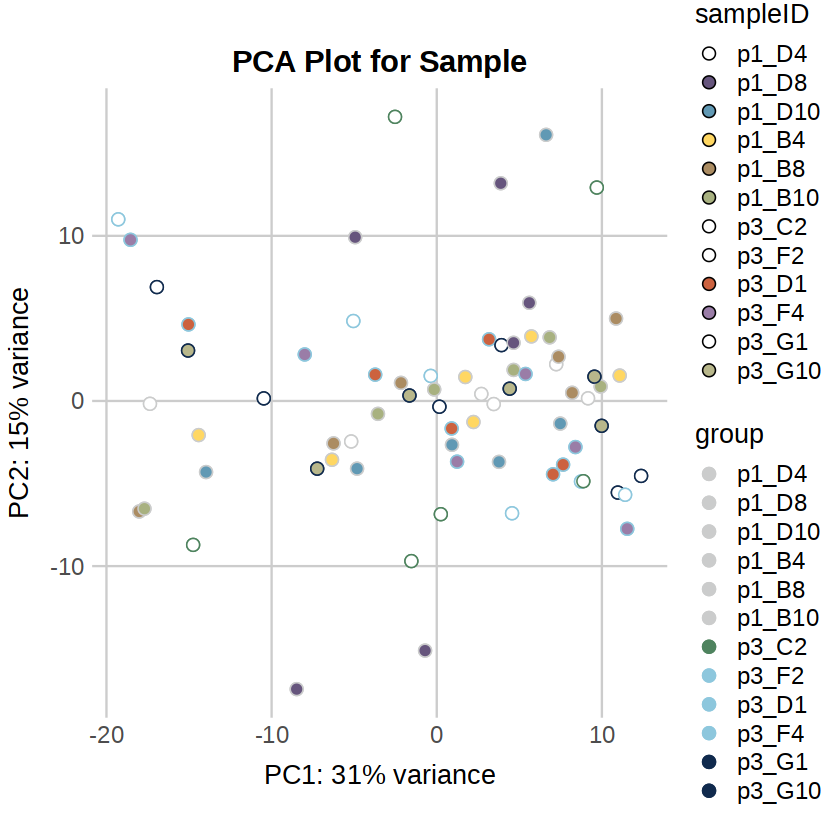

In [25]:
# Load necessary libraries
library(ggplot2)
library(DESeq2)  # Assuming you're using DESeq2 for vsd_samplecorr

# Step 1: Define sample to ID mapping and two color mappings
sample2ID <- c(
  '1' = 'p1_D4',
  '2' = 'p1_D8',
  '3' = 'p1_D10',
  '4' = 'p1_B4',
  '5' = 'p1_B8',
  '6' = 'p1_B10',
  '7' = 'p3_C2',
  '8' = 'p3_F2',
  '9' = 'p3_D1',
  '10' = 'p3_F4',
  '11' = 'p3_G1',
  '12' = 'p3_G10'
)

fill_color_map <- c(
  'p1_D4' = '#ffffff',
  'p1_D8' = '#66557d',
  'p1_D10' = '#6199b4',
  'p1_B4' = '#ffd762',
  'p1_B8' = '#ab8c62',
  'p1_B10' = '#a8b180',
  'p3_C2' = '#ffffff',
  'p3_F2' = '#ffffff',
  'p3_D1' = '#cc623f',
  'p3_F4' = '#9a7da7',
  'p3_G1' = '#ffffff',
  'p3_G10' = '#b8b78b'
)

outline_color_map <- c(
  'p1_D4' = '#CBCCCC',
  'p1_D8' = '#CBCCCC',
  'p1_D10' = '#CBCCCC',
  'p1_B4' = '#CBCCCC',
  'p1_B8' = '#CBCCCC',
  'p1_B10' = '#CBCCCC',
  'p3_C2' = '#4E835E',
  'p3_F2' = '#8DC7DD',
  'p3_D1' = '#8DC7DD',
  'p3_F4' = '#8DC7DD',
  'p3_G1' = '#102A4D',
  'p3_G10' = '#102A4D'
)

# Step 2: Map 'sample' numbers to their corresponding IDs
vsd_samplecorr$sampleID <- factor(sample2ID[as.character(vsd_samplecorr$sample)], levels = names(fill_color_map))

# Create the PCA plot for 'sample' with custom fill and outline colors
p_sample <- plotPCA(object = vsd_samplecorr, intgroup = c('sampleID')) +
  ggtitle('PCA Plot for Sample') +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
    axis.title.x = element_text(size = 16, margin = margin(t = 10)),
    axis.title.y = element_text(size = 16, margin = margin(r = 10)),
    axis.text.x = element_text(size = 14),
    axis.text.y = element_text(size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14),
    panel.grid.major = element_line(color = "gray80"),
    panel.grid.minor = element_blank()
  ) +
  geom_point(aes(color = sampleID, fill = sampleID), size = 3, shape = 21, stroke = 0.5) +
  scale_fill_manual(values = fill_color_map) +  # Apply custom fill colors
  scale_color_manual(values = outline_color_map)  # Apply custom outline colors

# Display the 'sample' plot in the notebook
print(p_sample)

# Save the 'sample' plot as a PDF file
ggsave("stability_plots/PCA_Plot_sample.pdf", plot = p_sample, width = 8, height = 6)


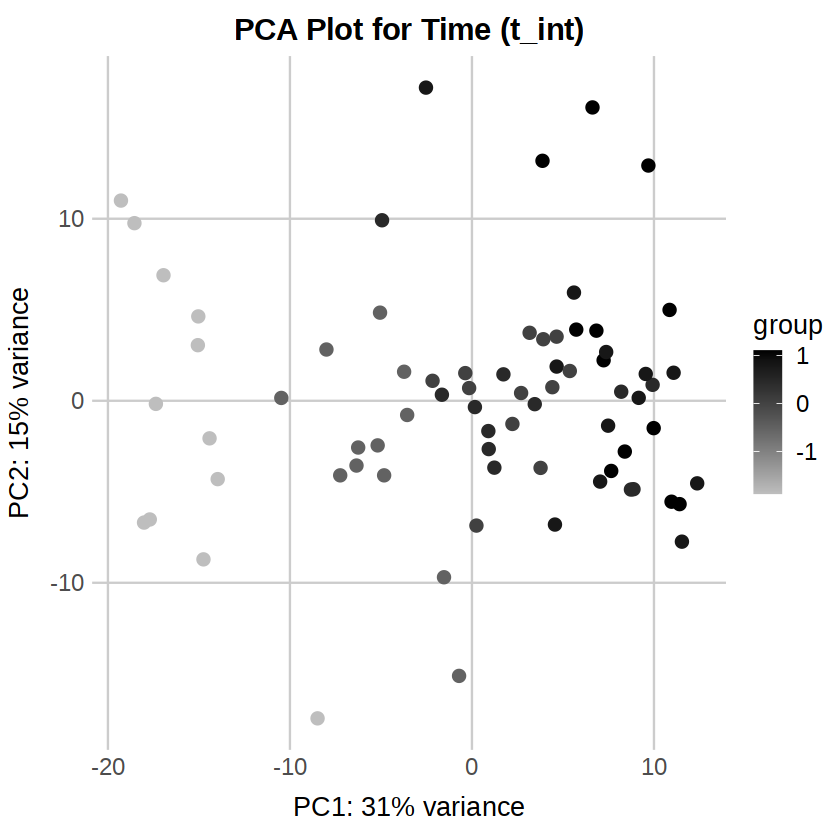

In [27]:
# Load necessary libraries
library(ggplot2)
library(DESeq2)  # Assuming you're using DESeq2 for vsd_samplecorr

# Create the PCA plot for 't_int' as a continuous variable
p_t_int <- plotPCA(object = vsd_samplecorr, intgroup = c('t_int')) +
  ggtitle('PCA Plot for Time (t_int)') +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
    axis.title.x = element_text(size = 16, margin = margin(t = 10)),
    axis.title.y = element_text(size = 16, margin = margin(r = 10)),
    axis.text.x = element_text(size = 14),
    axis.text.y = element_text(size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14),
    panel.grid.major = element_line(color = "gray80"),
    panel.grid.minor = element_blank()
  ) +
  scale_color_gradient(low = "grey", high = "black")  # Gradient from black to white

# Display the 't_int' plot in the notebook
print(p_t_int)

# Save the 't_int' plot as a PDF file
ggsave("stability_plots/PCA_Plot_t_int.pdf", plot = p_t_int, width = 8, height = 6)


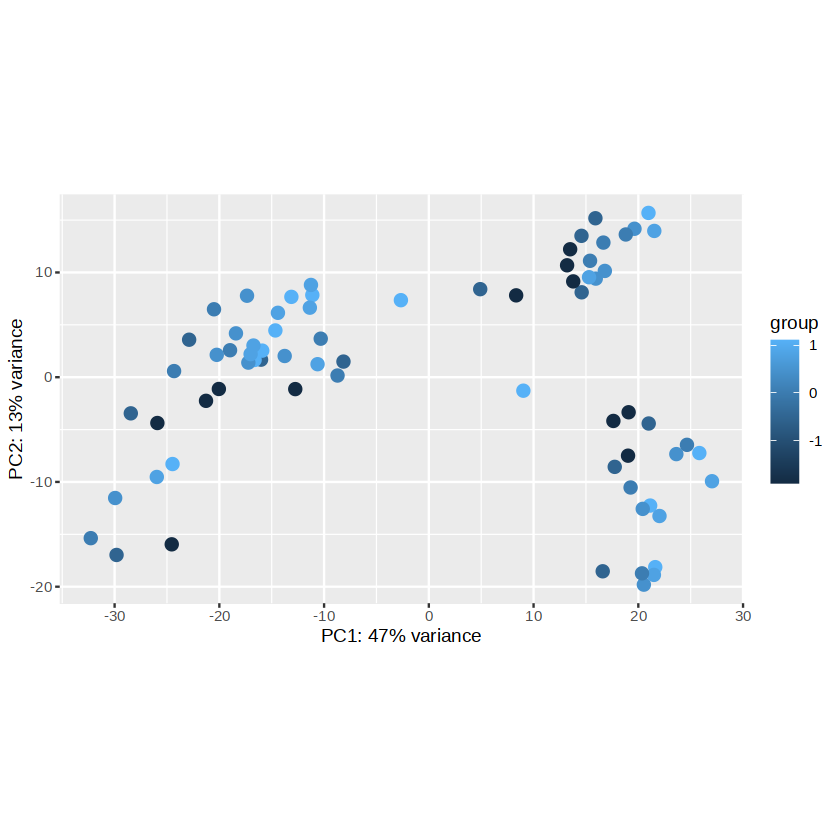

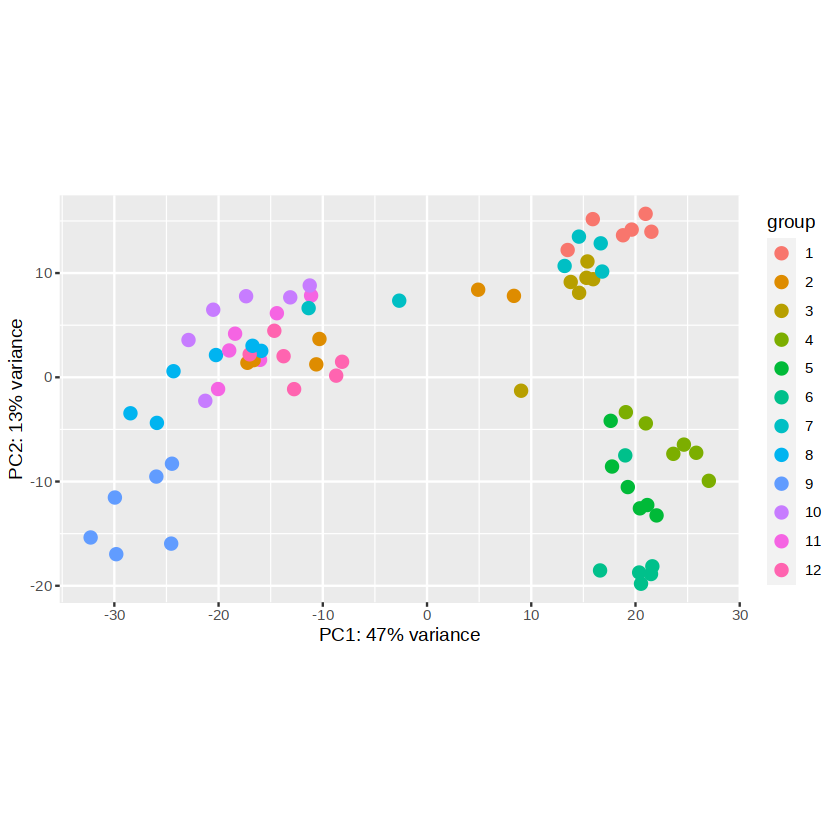

In [28]:
vsd_bk <- vsd
mat <- assay(vsd_bk)
mm <- model.matrix(~sample, colData(vsd_bk))
mat <- limma::removeBatchEffect(mat, batch=vsd_bk$t_int, design=mm)
assay(vsd_bk) <- mat
plotPCA(vsd_bk,intgroup=c('t_int'))
plotPCA(vsd_bk,intgroup=c('sample'))
vsd_tcorr <- vsd_bk

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



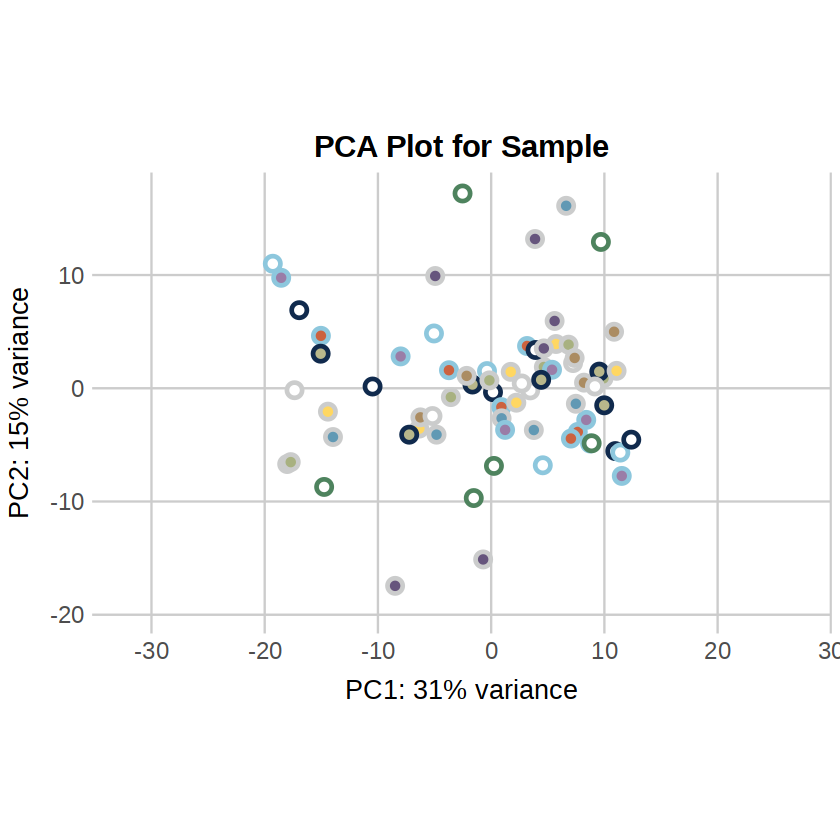

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



ERROR: Error in xlim(xlim): argument "xlim" is missing, with no default


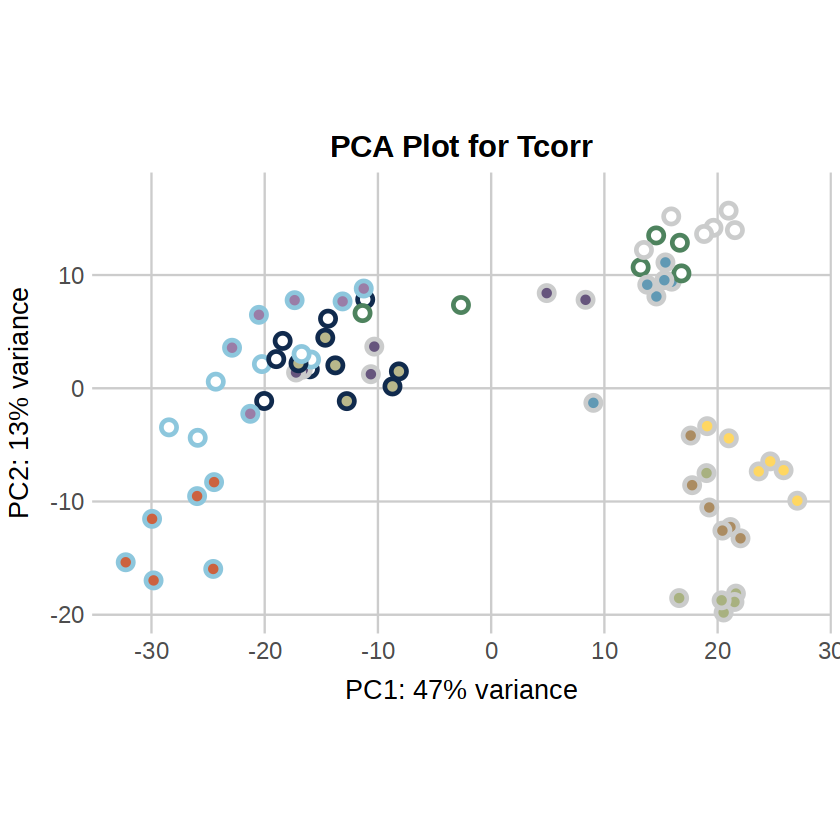

In [37]:
# Calculate the x and y limits based on both datasets
get_pca_limits <- function(vsd_object) {
  pca_data <- plotPCA(vsd_object, intgroup = c('sampleID'), returnData = TRUE)
  xlim <- range(pca_data$PC1)
  ylim <- range(pca_data$PC2)
  return(list(xlim = xlim, ylim = ylim))
}

# Calculate limits for both datasets
limits_samplecorr <- get_pca_limits(vsd_samplecorr)
limits_tcorr <- get_pca_limits(vsd_tcorr)

# Determine overall limits by taking the range across both datasets
overall_xlim <- range(limits_samplecorr$xlim, limits_tcorr$xlim)
overall_ylim <- range(limits_samplecorr$ylim, limits_tcorr$ylim)

# Create a function to ensure consistency
create_pca_plot <- function(vsd_object, title, fill_color_map, outline_color_map, filename, xlim, ylim) {
  
  # Map 'sample' numbers to their corresponding IDs (adjust this mapping if necessary)
  vsd_object$sampleID <- factor(sample2ID[as.character(vsd_object$sample)], levels = names(fill_color_map))
  
  # Generate the PCA plot
  p <- plotPCA(object = vsd_object, intgroup = c('sampleID')) +
    ggtitle(title) +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
      axis.title.x = element_text(size = 16, margin = margin(t = 10)),
      axis.title.y = element_text(size = 16, margin = margin(r = 10)),
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 14),
      panel.grid.major = element_line(color = "gray80"),
      panel.grid.minor = element_blank(),
      legend.position = "none"  # Remove the legend
    ) +
    geom_point(aes(color = sampleID, fill = sampleID), size = 3, shape = 21, stroke = 1.5) +
    scale_fill_manual(values = fill_color_map) +  # Apply custom fill colors
    scale_color_manual(values = outline_color_map) +  # Apply custom outline colors
    coord_fixed() +  # Ensures equal scaling for x and y axes
    xlim(xlim) +  # Apply common x limits
    ylim(ylim)    # Apply common y limits
  
  # Display the plot
  print(p)
  
  # Save the plot with consistent dimensions
  ggsave(filename, plot = p, width = 8, height = 6)
}

# Create PCA plots for vsd_samplecorr and vsd_tcorr with consistent settings
create_pca_plot(vsd_samplecorr, "PCA Plot for Sample", fill_color_map, outline_color_map, "stability_plots/PCA_Plot_samplecorr_test.pdf",overall_xlim, overall_ylim)

create_pca_plot(vsd_tcorr, "PCA Plot for Tcorr", fill_color_map, outline_color_map, "stability_plots/PCA_Plot_tcorr.pdf", overall_xlim, overall_ylim)


Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



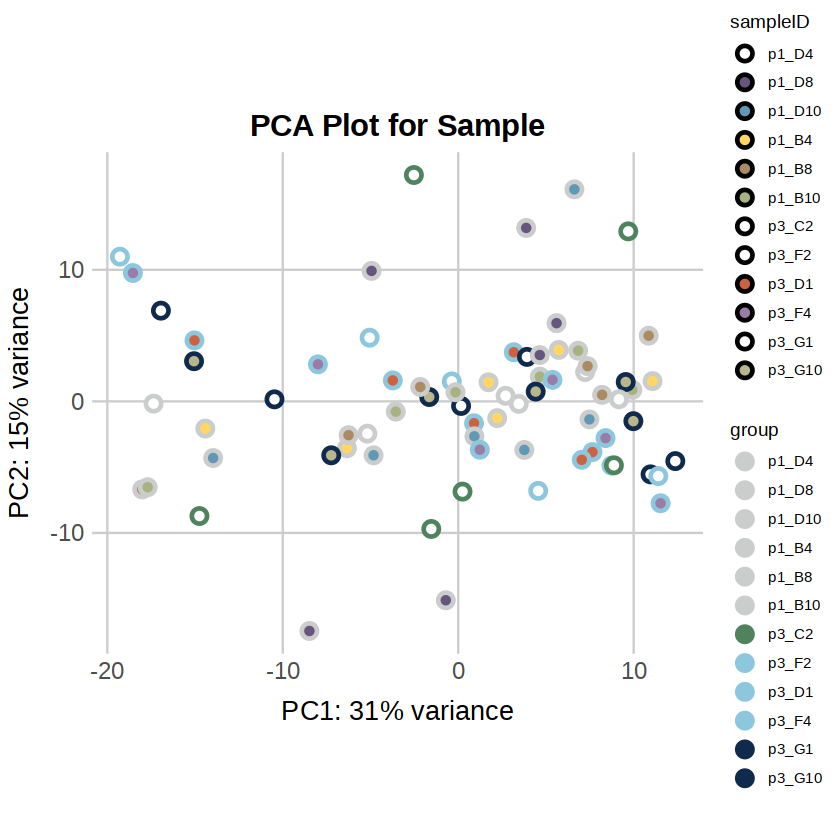

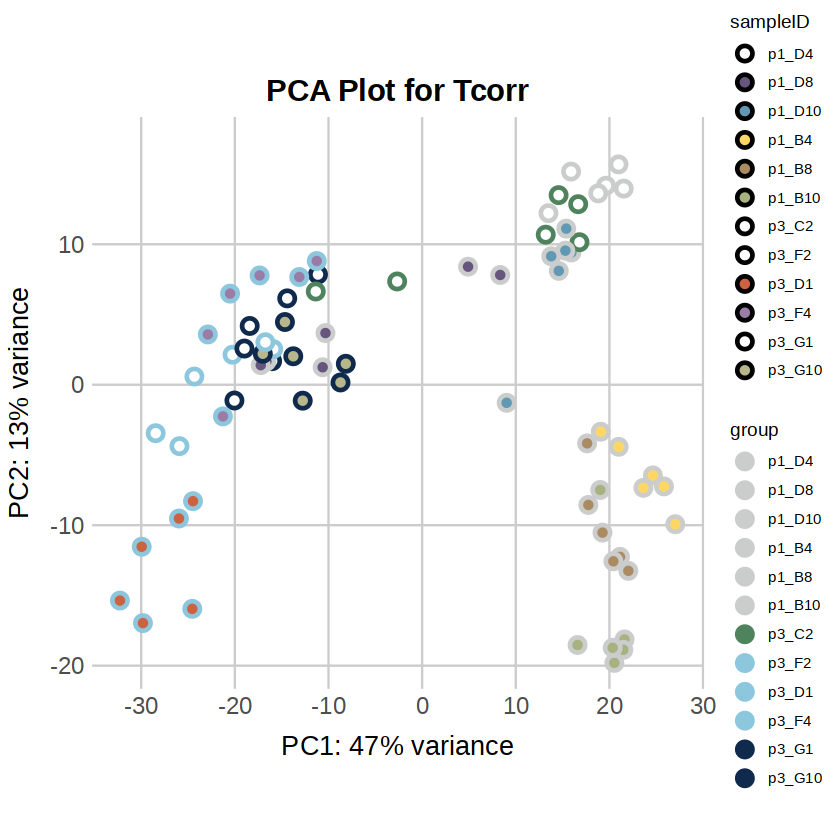

In [48]:
create_pca_plot <- function(
  vsd_object, 
  title, 
  plot_var,  # The variable to plot, e.g., sampleID
  filename, 
  fill_color_map = NULL,  # Optional: Fill color map
  outline_color_map = NULL,  # Optional: Outline color map
  xlim = NULL,  # Optional: X-axis limits
  ylim = NULL,  # Optional: Y-axis limits
  aspect_ratio = 1,  # Optional: Aspect ratio (default is 1:1)
  remove_legend = FALSE,  # Optional: Remove legend (default is FALSE)
  width = 8,  # Optional: Width of the saved plot
  height = 6  # Optional: Height of the saved plot
) {
  
  # Map 'plot_var' to factor levels if applicable
  vsd_object[[plot_var]] <- factor(vsd_object[[plot_var]])
  
  # Generate the PCA plot
  p <- plotPCA(object = vsd_object, intgroup = c(plot_var)) +
    ggtitle(title) +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
      axis.title.x = element_text(size = 16, margin = margin(t = 10)),
      axis.title.y = element_text(size = 16, margin = margin(r = 10)),
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 14),
      panel.grid.major = element_line(color = "gray80"),
      panel.grid.minor = element_blank()
    ) +
    geom_point(aes(color = !!sym(plot_var), fill = !!sym(plot_var)), size = 3, shape = 21, stroke = 1.5) +
    coord_fixed(ratio = aspect_ratio)  # Set aspect ratio
  
  # Apply custom fill colors if provided
  if (!is.null(fill_color_map)) {
    p <- p + scale_fill_manual(values = fill_color_map)
  }
  
  # Apply custom outline colors if provided
  if (!is.null(outline_color_map)) {
    p <- p + scale_color_manual(values = outline_color_map)
  }
  
  # Apply common x limits if provided
  if (!is.null(xlim)) {
    p <- p + xlim(xlim)
  }
  
  # Apply common y limits if provided
  if (!is.null(ylim)) {
    p <- p + ylim(ylim)
  }
  
  # Remove the legend if specified
  if (remove_legend) {
    p <- p + theme(legend.position = "none")
  }
  
  # Display the plot
  print(p)
  
  # Save the plot with the specified dimensions
  ggsave(filename, plot = p, width = width, height = height)
}

# Example usage without custom colors and limits, with legend removed
create_pca_plot(
  vsd_samplecorr, 
  "PCA Plot for Sample", 
  plot_var = "sampleID", 
  filename = "stability_plots/PCA_Plot_sample.pdf",
  fill_color_map = fill_color_map, 
  outline_color_map = outline_color_map, 
  aspect_ratio = 0.75,  # Custom aspect ratio
  remove_legend = FALSE,  # Remove legend
  width = 6,  # Custom width
  height = 6  # Custom height
)

# Example usage with custom colors, limits, aspect ratio, and legend included
create_pca_plot(
  vsd_tcorr, 
  "PCA Plot for Tcorr", 
  plot_var = "sampleID", 
  filename = "stability_plots/PCA_Plot_tcorr.pdf", 
  fill_color_map = fill_color_map, 
  outline_color_map = outline_color_map, 
  xlim = overall_xlim, 
  ylim = overall_ylim, 
  aspect_ratio = 1.5,  # Custom aspect ratio
  remove_legend = FALSE,  # Keep legend
  width = 6,  # Custom width
  height = 6  # Custom height
)


Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



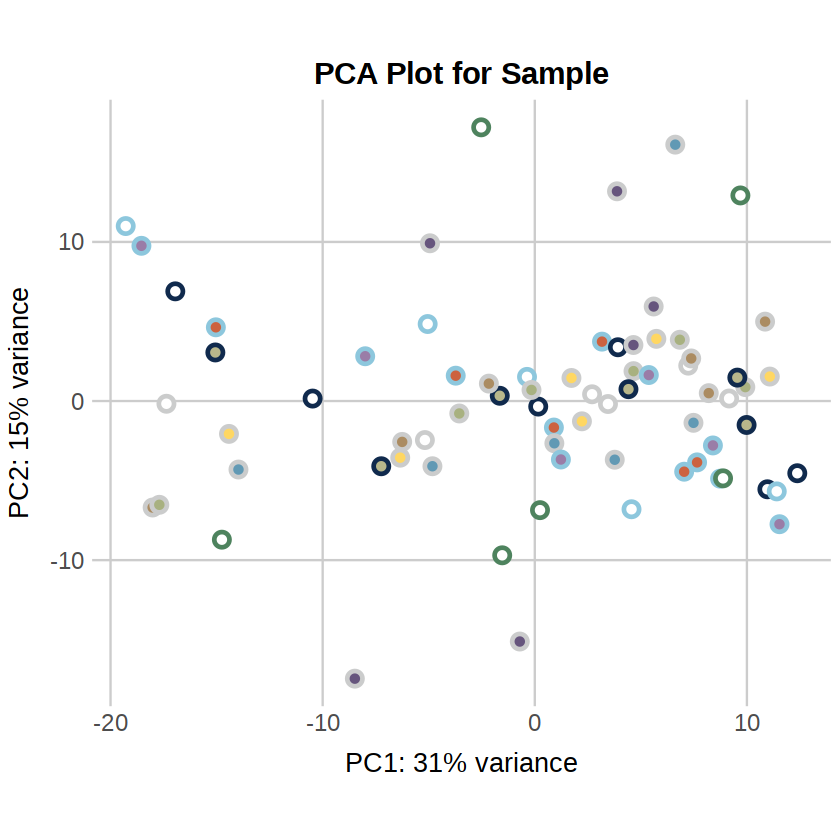

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



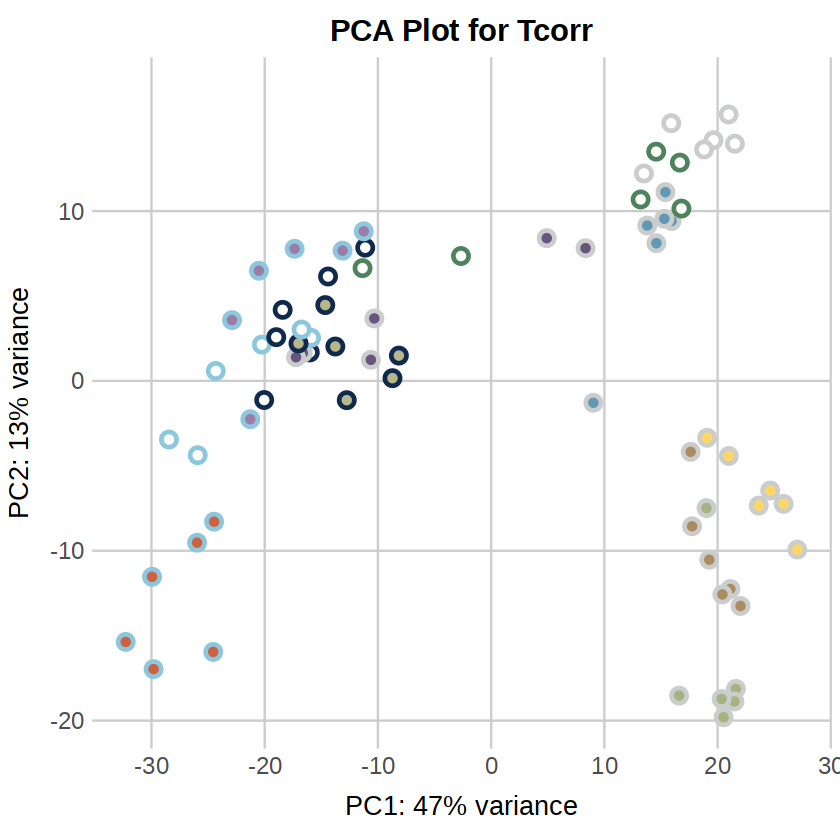

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



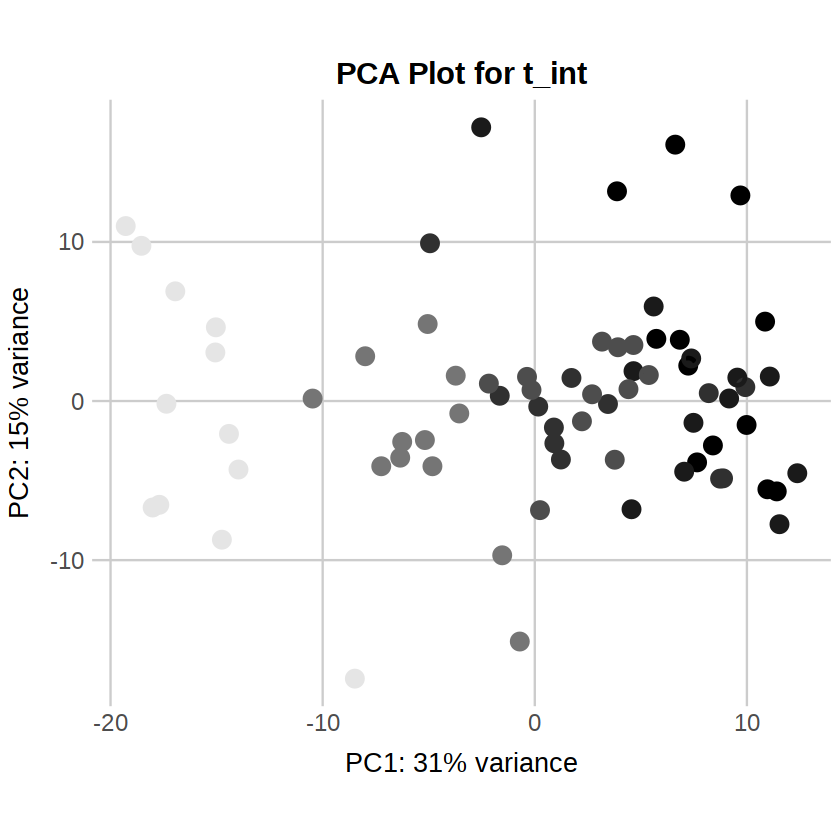

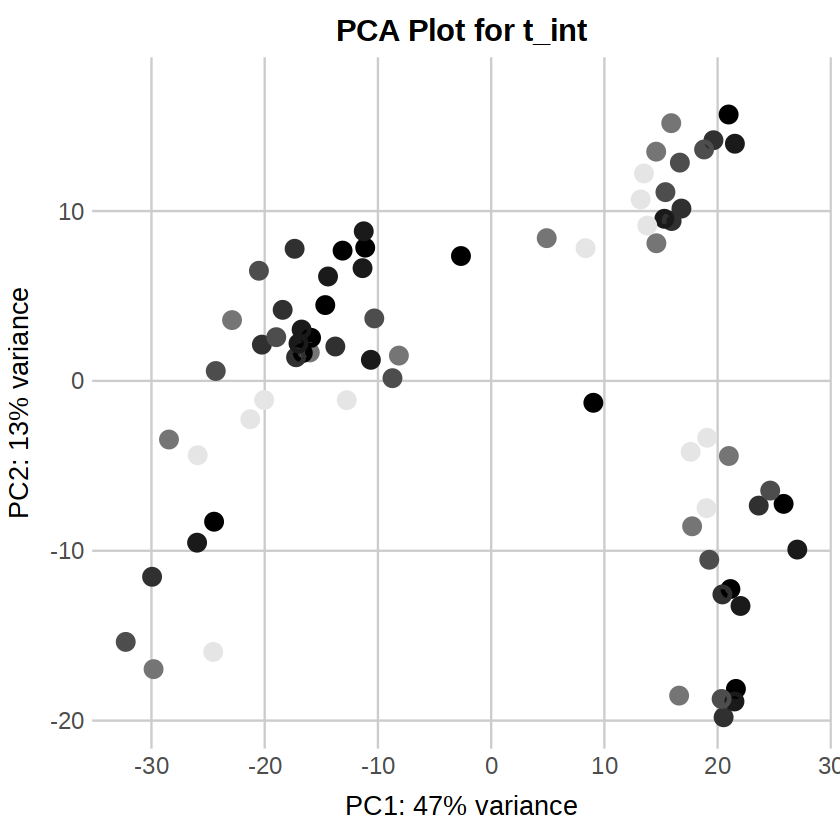

In [54]:
quantitative_pca_plot <- function(
  vsd_object, 
  title, 
  plot_var,  # The continuous variable to plot, e.g., t_int
  filename, 
  color_map = scale_color_gradient(low = "gray90", high = "black"),  # Default: grayscale from gray to black
  xlim = NULL,  # Optional: X-axis limits
  ylim = NULL,  # Optional: Y-axis limits
  aspect_ratio = 1,  # Optional: Aspect ratio (default is 1:1)
  remove_legend = FALSE,  # Optional: Remove legend (default is FALSE)
  width = 8,  # Optional: Width of the saved plot
  height = 6  # Optional: Height of the saved plot
) {
  
  # Ensure that plot_var is treated as a numeric variable
  vsd_object[[plot_var]] <- as.numeric(vsd_object[[plot_var]])
  
  # Generate the PCA plot
  p <- plotPCA(object = vsd_object, intgroup = c(plot_var)) +
    ggtitle(title) +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
      axis.title.x = element_text(size = 16, margin = margin(t = 10)),
      axis.title.y = element_text(size = 16, margin = margin(r = 10)),
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 14),
      panel.grid.major = element_line(color = "gray80"),
      panel.grid.minor = element_blank()
    ) +
    geom_point(aes(color = !!sym(plot_var)), size = 3, shape = 21, stroke = 1.5) +
    coord_fixed(ratio = aspect_ratio)  # Set aspect ratio
  
  # Apply custom color map
  p <- p + color_map
  
  # Apply common x limits if provided
  if (!is.null(xlim)) {
    p <- p + xlim(xlim)
  }
  
  # Apply common y limits if provided
  if (!is.null(ylim)) {
    p <- p + ylim(ylim)
  }
  
  # Remove the legend if specified
  if (remove_legend) {
    p <- p + theme(legend.position = "none")
  }
  
  # Display the plot
  print(p)
  
  # Save the plot with the specified dimensions
  ggsave(filename, plot = p, width = width, height = height)
}


# Example usage without custom colors and limits, with legend removed
create_pca_plot(
  vsd_samplecorr, 
  "PCA Plot for Sample", 
  plot_var = "sampleID", 
  filename = "stability_plots/PCA_Plot_sample.pdf",
  fill_color_map = fill_color_map, 
  outline_color_map = outline_color_map, 
  aspect_ratio = 0.75,  # Custom aspect ratio
  remove_legend = TRUE,  # Remove legend
  width = 6,  # Custom width
  height = 6  # Custom height
)

# Example usage with custom colors, limits, aspect ratio, and legend included
create_pca_plot(
  vsd_tcorr, 
  "PCA Plot for Tcorr", 
  plot_var = "sampleID", 
  filename = "stability_plots/PCA_Plot_tcorr.pdf", 
  fill_color_map = fill_color_map, 
  outline_color_map = outline_color_map, 
  xlim = overall_xlim, 
  ylim = overall_ylim, 
  aspect_ratio = 1.5,  # Custom aspect ratio
  remove_legend = TRUE,  # Keep legend
  width = 6,  # Custom width
  height = 6  # Custom height
)


# Example usage with default grayscale color map
quantitative_pca_plot(
  vsd_samplecorr, 
  "PCA Plot for t_int", 
  plot_var = "t_int", 
  filename = "stability_plots/PCA_Plot_t_int.pdf",
  aspect_ratio = 0.75,  # Custom aspect ratio
  remove_legend = TRUE,  # Remove legend
  width = 6,  # Custom width
  height = 6  # Custom height
)

# Example usage with a custom color gradient and legend removed
quantitative_pca_plot(
  vsd_tcorr, 
  "PCA Plot for t_int", 
  plot_var = "t_int", 
  filename = "stability_plots/PCA_Plot_t_int_custom.pdf", 
  xlim = overall_xlim, 
  ylim = overall_ylim, 
  aspect_ratio = 1.5,  # Custom aspect ratio
  remove_legend = TRUE,  # Remove legend
  width = 6,  # Custom width
  height = 6  # Custom height
)


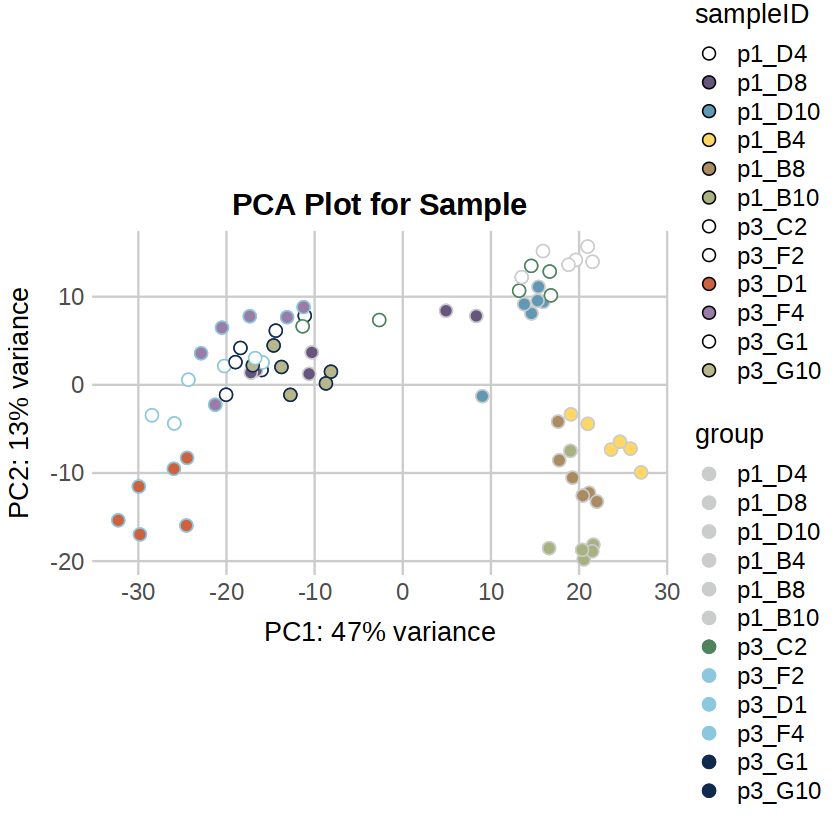

In [29]:
# Load necessary libraries
library(ggplot2)
library(DESeq2)  # Assuming you're using DESeq2 for vsd_samplecorr

# Step 1: Define sample to ID mapping and two color mappings
sample2ID <- c(
  '1' = 'p1_D4',
  '2' = 'p1_D8',
  '3' = 'p1_D10',
  '4' = 'p1_B4',
  '5' = 'p1_B8',
  '6' = 'p1_B10',
  '7' = 'p3_C2',
  '8' = 'p3_F2',
  '9' = 'p3_D1',
  '10' = 'p3_F4',
  '11' = 'p3_G1',
  '12' = 'p3_G10'
)

fill_color_map <- c(
  'p1_D4' = '#ffffff',
  'p1_D8' = '#66557d',
  'p1_D10' = '#6199b4',
  'p1_B4' = '#ffd762',
  'p1_B8' = '#ab8c62',
  'p1_B10' = '#a8b180',
  'p3_C2' = '#ffffff',
  'p3_F2' = '#ffffff',
  'p3_D1' = '#cc623f',
  'p3_F4' = '#9a7da7',
  'p3_G1' = '#ffffff',
  'p3_G10' = '#b8b78b'
)

outline_color_map <- c(
  'p1_D4' = '#CBCCCC',
  'p1_D8' = '#CBCCCC',
  'p1_D10' = '#CBCCCC',
  'p1_B4' = '#CBCCCC',
  'p1_B8' = '#CBCCCC',
  'p1_B10' = '#CBCCCC',
  'p3_C2' = '#4E835E',
  'p3_F2' = '#8DC7DD',
  'p3_D1' = '#8DC7DD',
  'p3_F4' = '#8DC7DD',
  'p3_G1' = '#102A4D',
  'p3_G10' = '#102A4D'
)

# Step 2: Map 'sample' numbers to their corresponding IDs
vsd_tcorr$sampleID <- factor(sample2ID[as.character(vsd_tcorr$sample)], levels = names(fill_color_map))

# Create the PCA plot for 'sample' with custom fill and outline colors
p_sample <- plotPCA(object = vsd_tcorr, intgroup = c('sampleID')) +
  ggtitle('PCA Plot for Sample') +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
    axis.title.x = element_text(size = 16, margin = margin(t = 10)),
    axis.title.y = element_text(size = 16, margin = margin(r = 10)),
    axis.text.x = element_text(size = 14),
    axis.text.y = element_text(size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14),
    panel.grid.major = element_line(color = "gray80"),
    panel.grid.minor = element_blank()
  ) +
  geom_point(aes(color = sampleID, fill = sampleID), size = 3, shape = 21, stroke = 0.5) +
  scale_fill_manual(values = fill_color_map) +  # Apply custom fill colors
  scale_color_manual(values = outline_color_map)  # Apply custom outline colors

# Display the 'sample' plot in the notebook
print(p_sample)

# Save the 'sample' plot as a PDF file
ggsave("stability_plots/PCA_Plot_sample_tcorr.pdf", plot = p_sample, width = 8, height = 6)


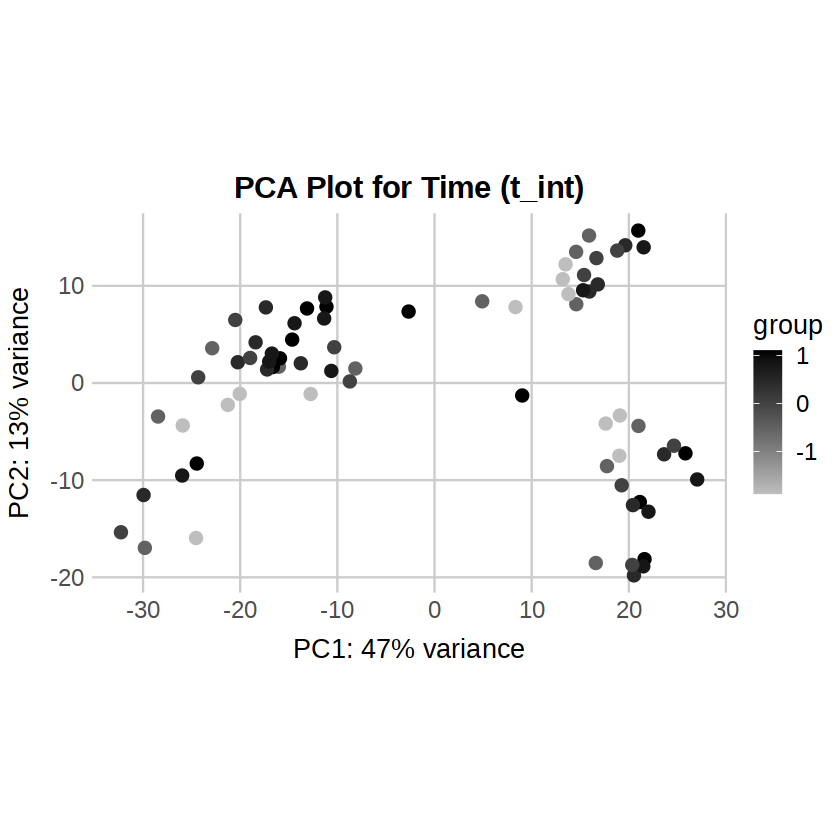

In [30]:
# Load necessary libraries
library(ggplot2)
library(DESeq2)  # Assuming you're using DESeq2 for vsd_samplecorr

# Create the PCA plot for 't_int' as a continuous variable
p_t_int <- plotPCA(object = vsd_tcorr, intgroup = c('t_int')) +
  ggtitle('PCA Plot for Time (t_int)') +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
    axis.title.x = element_text(size = 16, margin = margin(t = 10)),
    axis.title.y = element_text(size = 16, margin = margin(r = 10)),
    axis.text.x = element_text(size = 14),
    axis.text.y = element_text(size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14),
    panel.grid.major = element_line(color = "gray80"),
    panel.grid.minor = element_blank()
  ) +
  scale_color_gradient(low = "grey", high = "black")  # Gradient from black to white

# Display the 't_int' plot in the notebook
print(p_t_int)

# Save the 't_int' plot as a PDF file
ggsave("stability_plots/PCA_Plot_t_int_tcorr.pdf", plot = p_t_int, width = 8, height = 6)


In [ ]:
#Calculate distances for PCA
sampleDists <- dist(t(assay(vsd_orig)))
tst <- as.data.frame(as.matrix(sampleDists))
write.table(tst,"bulk/stability_time_deseq2_pca_distances_noFilter.tsv",sep = "\t")

sampleDists <- dist(t(assay(vsd_samplecorr)))
tst <- as.data.frame(as.matrix(sampleDists))
write.table(tst,"bulk/stability_time_deseq2_limma_corrS_pca_distances_noFilter.tsv",sep = "\t")

sampleDists <- dist(t(assay(vsd_tcorr)))
tst <- as.data.frame(as.matrix(sampleDists))
write.table(tst,"bulk/stability_time_deseq2_limma_corrT_pca_distances_noFilter.tsv",sep = "\t")


In [25]:
write.table(assay(vsd_orig),"bulk/stability_time_deseq2_vsd_noFilter.tsv",sep = "\t")
write.table(assay(vsd_samplecorr),"bulk/stability_time_deseq2_vsd_corrS_noFilter.tsv",sep = "\t")
write.table(assay(vsd_tcorr),"bulk/stability_time_deseq2_vsd_corrT_noFilter.tsv",sep = "\t")


## Summary and Session Information

This notebook has completed the following analyses:

1. **Data Loading**: Loaded RNA-seq count data and metadata
2. **Quality Control**: Analyzed library sizes and sample distributions
3. **Data Filtering**: Applied count thresholds to remove low-quality samples and genes
4. **DESeq2 Analysis**: Performed differential expression analysis with batch correction
5. **PCA Analysis**: Generated PCA plots before and after batch correction
6. **Visualization**: Created publication-ready plots with consistent styling

All output plots have been saved to the `stability_plots/` directory.

In [ ]:
# =============================================================================
# SESSION INFORMATION FOR REPRODUCIBILITY
# =============================================================================

cat("Analysis completed at:", as.character(Sys.time()), "\n")
cat("Total runtime: \n")

# Print session information
cat("\n=== R SESSION INFORMATION ===\n")
sessionInfo()

# Print package versions for key packages
cat("\n=== KEY PACKAGE VERSIONS ===\n")
key_packages <- c("DESeq2", "ggplot2", "dplyr", "limma", "pheatmap")
for (pkg in key_packages) {
  if (requireNamespace(pkg, quietly = TRUE)) {
    cat(pkg, "version:", as.character(packageVersion(pkg)), "\n")
  }
}

cat("\n=== ANALYSIS PARAMETERS USED ===\n")
cat("Minimum count threshold:", MIN_COUNT_THRESHOLD, "\n")
cat("Minimum reads per gene:", MIN_READS_PER_GENE, "\n")
cat("P-value cutoff:", P_VALUE_CUTOFF, "\n")
cat("Fold change cutoff:", FC_CUTOFF, "\n")

cat("\nAnalysis completed successfully!\n")